<img src="img/ENSAE_logo.jpg">

**"Éléments logiciels pour le traitement des données massives", S1 2018-19** 
# *Parallelised Community Detection with Spark MapReduce*  

  
**Alban CHAMPEVILLE**, *Mastère Spécialisé Data Science, ENSAE ParisTech*  
**Yosuke IJIRI**, *Mastère Spécialisé Data Science, ENSAE ParisTech*  
  

## Abstract

This project implements a parallelised community detection algorithm proposed by [*Moon, et al. (2015)*.](http://dx.doi.org/10.1016/j.datak.2015.05.001) The model is based on Girvan-Newman Algorithm. For parallelisation, we run Spark using Python on our dual-core laptop with 4 logical CPUs. Our code can easily be adapted for much larger datasets by scaling out to distributed computing with cloud environments such as AWS and Microsoft Azure.

## Overview

In [306]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## 1. Introduction & Literature Review

Analysing network datum has become a key issue in many areas to base suggestions, advices and strategies in many sectors and applications. In Data Science, K-mean clustering and community detection method are the two main approaches to analyse networks in applications such as anomaly detection and recommendation system.

In our project, we employ community detection which allows us to identify clusters in a graph network with nodes and edges by regrouping nodes into groups of densely connected nodes.

<img src="img/network.png" width="400" align="left">

Community detection is a process to partition the set of network nodes into multiple groups such that the nodes within a group are connected densely, but connections between groups are sparse. Popular algorithms of community detection include Girvan-Newman, Louvain and Walktrap. Other popular algorithms and methodologies are compared in [*Algesheimer, et al. (2016)*](https://www.nature.com/articles/srep30750).

The Girvan-Newman algorithm [(*Girvan and Newman (2004)*)](http://www.cse.cuhk.edu.hk/~cslui/CMSC5734/newman_community_struct_networks_phys_rev.pdf) exploits the concept of edge betweenness, a measure of the centrality and influence of an edge in a network. The edges connecting communities are expected to have high edge betweenness. The underlying community structure of the network will be much clear after removing edges with high edge betweenness. There are two major definitions of edge betweenness: shortest-path betweenness and random-walk betweenness.

We find the shortest paths between all pairs of nodes and count how many run along each edge. *Girvan and Newman (2004)* suggest that *"for most problems, we recommend the algorithm with ... shortest-path betweenness measure ... This measure appears to work well and is the quickest"* and that *"The other versions ... make greater computational demands, and in practice seem to give results no better than the shortest-path method"*. In order to compute the total shortest-path betweenness for all edges, it takes $\mathcal{O}(EN)$; therefore, the complete community structure algorithm is $\mathcal{O}(E^2N)$ (with E edges and N nodes). The random-walk betweenness which requires to calculate how often on average random walks starting at node s will pass down a particular edge from node v to node w (or vice versa) before finding their way to a given target node t. But it cannot produce a local maximum in the modularity unlike the shortest-path method.

The Louvain algorithm [(*Blondel et al. (2008)*)](https://pdfs.semanticscholar.org/b434/c0199bbf38163abd5f995e76aa1619d39db9.pdf), which looks first for "small" communities by optimizing modularity locally. It aggregates in a second time nodes belonging to the same community and builds a new network whose nodes are the communities. These 2 steps are repeated iteratively until a maximum of modularity is reached and a hierarchy of communities is produced. This method allows community detections on networks of 2 million nodes within 2 minutes on a standard PC.

The Walktrap [(*Pons and Latapy (2005)*)](https://www-complexnetworks.lip6.fr/~latapy/Publis/communities.pdf) method utilises that random walkers tends to get ‘trapped’ into more densely connected group.

Although the Girvan-Newman algorithm with shortest-path betweenness methodology is proved to be one of the most efficient community detection algorithms, it has limitations in supporting large-scale networks since it needs to calculate the shortest path between every pair of nodes which lead Newman and Girvan to mention in 2004 *"In our experience, this typically makes it tactable for networks of up to about n=10000 nodes, with current desktop computers"*, whose capability is relatively small if we compare with the capability of 2 million nodes of the Louvain.

In this context, and given the expanding size of networks today, parallelisation of calculation is key to realize the task efficiently, and thus our work is focused on the MapReduce version of Girvan-Newman algorithm based on shortest-path betweeness which allows us to process large network data. In the model, that is explained in the next section, each of the 4 stages contains Map-Reduce functions parallelized on machine's threads.

## 2. Model

- The MapReduce shortest-path betweenness Girvan-Newman algorithm processes data in four stages with tuples output of each stage being chained to the input of the next stage. Each stage executes its own map and reduce tasks. An iteration (round) of these four stages produces a community detection result. In each iteration, Stage1 is executed multiple times, and the other stages are executed only once. The four stages repeat until the result quality no longer improves. This quality is measured by a modularity Q (method detailed in this notebook). We run the model until the value of Q reaches a negative value; the best community structure is determined at the point where the quality of communities does not improve any more (at the top of the Q curve).


- A tuple of 7 elements is maintained for each pair of nodes in the process of community detection. It holds the network structure (i.e., an adjacency list), the shortest path obtained so far, and so on:
    - **targetId** indicates the destination node of a shortest path and is initially set to be sourceId.
    - **sourceId** indicates the source node of a shortest path and is initially set to be targetId.
    - **distance** indicates the length of a shortest path and is initially set to be 0. The value of distance is updated in each iteration of Stage 1.
    - **status** indicates the status of a specific path. a is “active”, and i is “inactive” meaning that the shortest path is already detected.
    - **weight** indicates the number of the shortest paths from sourceId to targetId and is initially set to be 1.
    - **pathInfo** indicates the list of the nodes on a shortest path and is initially set to be null.
    - **adjList** indicates the list of the nodes adjacent to targetId.

### 2.1. Algorithm

- The algorithm is splited in 4 stages executed sequentially:

    - [Stage 1]: finds all pair shortest paths (Breadth-first search). In short, each round of this algorithm cuts $k_{itr}$ (= 1 by default) edges based on shortest path betweenness, and measures the strength (modularity) of its community structure.
    - [Stage 2]: calculates edge betweenness. Total weight of edges are computed given their importance in shorter paths between 2 nodes.
    - [Stage 3]: selects the edges to be removed. $k_{itr}$ edges are selected according to edge betweenness. $k_{itr}$ can be specified by a user as a tuning parameter. One in the case of our Notebook.
    - [Stage 4]: removes the edges. Edges selected by Stage 3 are removed from the network. This will impact edge betweeness in next iterations.

- At the end of Stage 4 of each round, the strength (Q) of its community structure is measured. The best community division can be found at the round that gives the largest value of Q.

- The pseudocode of Girvan-Newman Algorithm with MapReduce is described below.

<img src="img/algo.png" width="450" align="left">

### 2.2. Data
- We have 6 network graph datasets with different number of nodes and edges.  
(Some of the datasets are pre-processed in order to be adapted for our algorithm and purpose.)

| No. | Data set     |  Number of nodes & edges  |  Source |
|--- |-----------| ------------  |  ---|
| 1 |test.txt | 21 nodes, 31 edges  |  [Newman and Girvan (2004)](http://www.cse.cuhk.edu.hk/~cslui/CMSC5734/newman_community_struct_networks_phys_rev.pdf)|
| 2 |soc-karate.txt | 34 nodes, 78 edges  |  [Mark Newman's web page](http://www-personal.umich.edu/~mejn/netdata/)|
| 3 |Test100.txt | 103 nodes, 239 edges  |  
| 4 |soc-physicians.txt | 241 nodes, 923 edges  |  [Network Repository](http://networkrepository.com/soc.php)|
| 5 |soc-ANU-residence_large.txt | 217 nodes, 1839 edges  |  [Network Repository](http://networkrepository.com/soc.php)|
| 6 |email-Eu-core.txt | 986 nodes, 16064 edges  | [Stanford Large Network Dataset Collection](https://snap.stanford.edu/data/)  |

- Visualisation examples:
<table><tr>
<td> <img src="./img/dataset3.png" alt="Drawing" style="width: 400px;"/> </td>  
<td> <img src="./img/dataset5.png" alt="Drawing" style="width: 400px;"/> </td>  
<td> <img src="./img/dataset6.png" alt="Drawing" style="width: 400px;"/> </td>
</tr></table>

- Among these 6 datasets, we chose "2_soc-karate" data as our benchmark. This dataset is from Zachary’s Karate Club data (Zachary 1977), which describes social network friendships between 34 members of a karate club at a U.S. university in the 1970s. This is one of the standard publicly available data sets for testing community detection algorithms. It contains 34 nodes (members) and 78 links (friendships). NodeId=1 is a part-time instructor and nodeId=33 is the captain of the club. There was a split in the club due to the difference of opinion on the club management between the instructor and the captain.

### 2.3. Environment
We run Spark using Python on our dual-core laptop with 4 logical CPUs (hyper-threading technology).

- Specification  
    - Hardware: MacBook Pro (Mid 2014)  
    - OS: macOS Mojave, Version 10.14.3
    - CPU: Intel(R) Core(TM) i5-4278U CPU, 2.6GHz, dual core
    - Memory: 8GB 1600 MHz DDR3  
- Language: Python
- Parallelisation method: Spark (pyspark)



## 3. Implementation

In [1]:
# Import libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
from operator import add
from copy import deepcopy
import time
from IPython.display import HTML
from pyspark import SparkContext, SparkConf

- We load a dataset from the 6 options

In [52]:
# Load a dataset from the 6 options

#file, nb_slice = '1_test.txt', None  # 21 nodes,31 edges
file, nb_slice = '2_soc-karate.txt', None  # 34 nodes,78 edges
#file, nb_slice = '3_Test100.txt', 100  # 103 nodes,239 edges
#file, nb_slice = '4_soc-physicians.txt', 500  # 241 nodes, 923 edges
#file, nb_slice = '5_soc-ANU-residence_large.txt', 500  # 217 nodes, 1839 edges
#file, nb_slice = '6_email-Eu-core.txt', 1000  # 986 nodes, 16064 edges

data = np.loadtxt('./Data/' + file, dtype='uint16')

print(type(data))
print(data[:5])  # Display the first 5 rows of the loaded dataset

<class 'numpy.ndarray'>
[[2 1]
 [3 1]
 [4 1]
 [5 1]
 [6 1]]


In [53]:
# Define dictionaries to store execution time histories.
# We use them in 4. Result and Discussion to draw result graphs.
try:  # Do nothing if these variables are already defined
    stage_time_dict
    total_time_dict
except NameError:
    stage_time_dict = {}
    total_time_dict = {}

<a id='Spark Configuration'></a>

### 3.1. Spark Configuration
- We first start SparkContext by specifying the number of threads to be used.
- (After running this cell, in case of re-execution, re-execute from <a href='#Adjacency List Creation'>here</a>.)

In [73]:
# Stop SparkContext if it is already running
try:
    sc.stop()
except NameError:
    pass

configuration = (SparkConf()
        .setMaster("local[4]")  # Specify the number of threads (cores) to be used
        .setAppName("ELTDM")
        .set('spark.executor.memory', '1g')  # Memory of the executor of each thread
        .set('spark.driver.memory', '1g')  # Memory of the driver of the executors
        .set('spark.driver.host', 'localhost')
        .set('spark.speculation', True)  # Task(s) running slowly in a stage will be re-launched
        .set('spark.speculation.multiplier', '1.5')  # Re-launch a task when it is 1.5 times slower than the median
        .set('spark.cleaner.periodicGC.interval', '30min'))  # Controls how often (5mins) to trigger a garbage collection
    
sc = SparkContext(conf = configuration)
nb_thread = sc.defaultParallelism
sc

<SparkContext master=local[4] appName=ELTDM>

In [74]:
sc._conf.getAll()

[('spark.cleaner.periodicGC.interval', '30min'),
 ('spark.speculation.multiplier', '1.5'),
 ('spark.master', 'local[4]'),
 ('spark.app.name', 'ELTDM'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.host', 'localhost'),
 ('spark.driver.memory', '1g'),
 ('spark.driver.port', '50941'),
 ('spark.speculation', 'True'),
 ('spark.executor.memory', '1g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.id', 'local-1551099591604'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

### 3.2. Data Preparation
- Before proceeding, we clean up the dataset (edge list) according to the below three criteria:  
    [Criterion 1] Put the node with smaller ID to the left for each edge data (e.g. [3 1] -> [1 3]) (undirectional network)  
    [Criterion 2] Filter out self-edge data (e.g. [2 2] -> delete)  
    [Criterion 3] Remove duplicate edges  

In [56]:
# Clean up the edge list
rdd = sc.parallelize(data)
d = rdd.map(lambda x: x if x[0] < x[1] else [x[1], x[0]]  # Criterion 1
           ).filter(lambda x: x[0] != x[1]).collect()  # Criterion 2
d = list(set(map(tuple, d)))  # Criterion 3
d = list(map(list, d))
print(type(d))

<class 'list'>


In [57]:
# Save the original node&edge information
nodes = list(set([n1 for n1, n2 in d] + [n2 for n1, n2 in d]))
nb_edges_initial = len(d)

print('The data contains %d distinct nodes, and %d distinct edges' % (len(nodes), nb_edges_initial))

The data contains 34 distinct nodes, and 78 distinct edges


- Let's visualise the initial network of the dataset.
- We can confirm that the nodeId=1 (instructor) and nodeId=33 (captain), the leader of each of the two factions, have many edges (friendships) connected to other nodes (members).

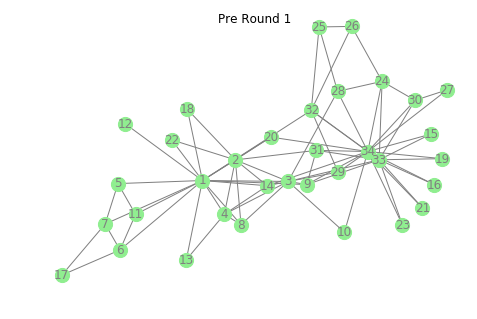

In [58]:
# Visualisation of the graph
n_size = 200  # node size: 200 for benckmark network
f_size = 12  # font size: 12 for benckmark network
l_width = 1.0  # edge width: 1.0 for benckmark network

def draw_initial_graph(graph):
    
    # Create networkx graph
    G=nx.Graph()
    
    # Add nodes
    for node in nodes:
        G.add_node(node)
        
    # Add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])
        
    # Save the positions of the nodes
    pos=nx.get_node_attributes(G,'pos')

    # Configure the graph
    pos = nx.spring_layout(G)
    nx.draw(G, 
            pos, 
            with_labels = True,
            font_size = f_size,
            width= l_width,
            node_size = n_size,
            node_color = 'lightgreen', edge_color = 'gray', font_color = 'gray')
    
    # Save and display the graph
    plt.suptitle('Pre Round 1')
    plt.savefig('./Data/Figures/Post_Round_00.png')
    plt.show()
    plt.close()
    return pos

np.random.seed(seed=135)
pos = draw_initial_graph(d)  # Save the initial node positions

<a id='Adjacency List Creation'></a>

(In case of re-execution, run the below 3 cells.)

In [75]:
# Make a list of adjacency lists
# The first element of each adjacency list denotes the node of origin
adj_list = []

for n in nodes:
    
    adj = []

    # If a node in a edge data is the origin (n),
    # add the connected node to its adjacency list
    for i in range(len(d)):
        if d[i][0] == n:
            adj.append(d[i][1])
        if d[i][1] == n:
            adj.append(d[i][0])
    
    adj = list(set(adj)) 
    adj.insert(0, n)  # Label the adjacency list with the node ID of origin
    adj_list.append(adj)

print('Sample: Adjacency list of origin node ID %d is %s' %(adj_list[0][0], adj_list[0]))

Sample: Adjacency list of origin node ID 1 is [1, 32, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 18, 20, 22]


- The format of tuple is : (targetId, sourceId, distance, 'status', weight, [pathInfo], [adjList])

In [76]:
# Make tuple for each node
class tuples():
    def __init__(self, targetId, sourceId, distance, status, weight, pathInfo, adjList) :
        self.targetId = targetId
        self.sourceId = sourceId
        self.distance = distance
        self.status = status
        self.weight = weight
        self.pathInfo = pathInfo
        self.adjList = adjList

network = []

for n in nodes:
    
    # Create tuples
    v = tuples(targetId = n, sourceId = n, distance = 0, status = 'a', weight = 1, pathInfo = [], adjList = [])
    
    # Fill in adjList
    for i in range(len(adj_list)):
        if adj_list[i][0] == n:
            v.adjList = adj_list[i][1:len(adj_list[i])]
            break
            
    network.append([v.targetId, v.sourceId, v.distance, v.status, v.weight, v.pathInfo, v.adjList])

print('Sample: the first tuple is %s' %network[0])

Sample: the first tuple is [1, 1, 0, 'a', 1, [], [32, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 18, 20, 22]]


- Although it is not necessary to convert the input of the initial Stage1 Map into key-value format, we make this conversion in order to be able to put the output of the Stage4 Reduce directly to the Stage1 Map of the next round.

In [77]:
# Key-value conversion
rdd = sc.parallelize(network)
rdd = rdd.map(lambda x: (x[0], x[1:]))
output = rdd.collect()

(In case of re-execution, go to <a href='#Rounds Stage1-4'> 3.8. Rounds Stage1-4</a>)

### 3.3. Stage 1
- In this stage, the shortest paths between every pair of nodes in the network are calculated.
- This Map-Reduce stage (stage 1) repeats until all tuples have 'i' (inactive) for status.
- The outcome of the iteration of this stage should give a list of tuples which tells the shortest paths between every pair of nodes in the network.


#### Map 

- In the Map operation, the frontiers are expanded from every node to its adjacent nodes.
- If $status$ is 'a' (active), status is changed to 'i' (inactive), 1 is added to $distance$ and $targetId$ is added to $pathInfo$.
- In addition, new active tuples are generated by assigning each node in $adjList$ to $targetId$, with $distance$ and $pathInfo$ equal to those of the original tuple.
- Thus, this Map is characterised by **Breadth First Search**.

In [62]:
def stage1_map(p):  
    result = []
    if p[1][2] == 'a':
        p[1][2] = 'i'
        p[1][1] += 1
        p[1][4].append(p[0])
        x = deepcopy(p)
        result.append(x)
        temp = p[1][5].copy()
        for i in range(len(temp)):
            k = temp[i]
            p[1][2] = 'a'
            p[1][5] = []
            y = deepcopy(p)
            result.append((k, y[1]))
        return result
    else:
        els = deepcopy(p)
        result.append(els)
        return result

#### Reduce 

- In this Reduce operation, among the tuples sharing $sourceId$ and $targetId$, only the tuple that has the minimum value of distance survices.
- If two or more tuples have the same minimum, $weight$ is changed to the number of such tuples to remember the multiplicity of the shortest path.
<br />
<br />
- This Reduce part consists of 6 steps:  
1) Add *sourceId* to key  
2) Aggregate the values that belong to the same key  
3) Take only values that have the shortest distance in the same key  
4) Replace *weight* of such values $\in minList$ with the size of $minList$  
5) Flatten values and list the tuples  
6) Fill in any empty adjList

In [63]:
def join(x, y):
    # 4 conditional statements below to join values
    # with correct level of nesting
    if (type(x[0]) is list) and (type(y[0]) is not list):
        return x+[y]
    elif (type(x[0]) is not list) and (type(y[0]) is list):
        return [x]+y
    elif (type(x[0]) is not list) and (type(y[0]) is not list):
        return [x]+[y]
    else:
        return x+y
    isinstance(x[0], int)

In [64]:
def stage1_reduce(x):
    if type(x[1][0]) is list:
        m = x[1][0][0]
        for s in range(len(x[1])):
            if x[1][s][0] < m:
                m = x[1][s][0]
        minList = []
        # Drop tuple(s) with non-shortest distance
        for s in range(len(x[1])):
            if x[1][s][0] == m:
                minList.append(x[1][s])
        y = (x[0], minList)
        # Update weight
        for s in range(len(minList)):
            y[1][s][2] = len(minList)
        return y
    else:
        return x

In [65]:
def twokeys_to_onekey(x):
    k = x[0][0]
    v = [x[0][1]]
    v.extend(x[1])
    return k, v

### 3.4. Stage 2
- In this stage, the edge betweenneses of all eadges in the network are calculated.

#### Map & Reduce
- In the Map operation, unity is divided to each edge on a shortest path according to the **weight** of the shortest paths sharing **sourceId** and **targetId**.
- In the Reduce operation, the contribution of each shortest path is summed up for each stage.

In [66]:
def stage2_map(x):
    edges_on_the_path = []
    for i in range(len(x[1][4])-1):
        k = (x[1][4][i], x[1][4][i+1])
        w = x[1][3]
        edges_on_the_path.append((k, 1/w))
    return edges_on_the_path

### 3.5. Stage 3
- In this stage, $k_{iter}$ edges are selected according to edge betweenness. By default, $k_{iter} = 1$.

#### Map & Reduce

- There is no function to be defined here.
- Refer to Stage3 of <a href='#Rounds Stage1-4'>4.8. Rounds Stage1-4</a>.

### 3.6. Stage4
- In this stage, the edges selected by Stage 3 are removed from the network. Then, a new set of tuples are generated to reflect the removed edges since edge betweenness needs to be recalculated in the next round.

#### Map

In [67]:
def stage4_map(x):
    counter = 0
    output = []
    for i in range(len(distributed_cache)):
        if x[0] in distributed_cache[i][0]:
            counter += 1  # Increase counter if its key is affected by the removal of the edge(s)
            c = distributed_cache[i][0][not(distributed_cache[i][0].index(x[0]))]  # Take the corresponding node
            try:
                x[1][5].remove(c)  # Remove if the corresponding node exists in the adjList
            except ValueError:
                pass  # Pass otherwise
    if counter == 0:
        return [tuple(x)]
    else:
        new = (x[1][0], [x[1][0], 0, 'a', 1, [], []])
        return x, new

#### Reduce

In [68]:
def stage4_reduce(x, y):
    if x[2] == 'a' and y[2] == 'a':
        return x
    elif x[2] == 'a' and y[2] == 'i':
        x[5] = y[5].copy()
        return x
    elif x[2] == 'i' and y[2] == 'a':
        y[5] = x[5].copy()
        return y
    else:
        return x+y
def revision(x):  # To flatten the pressed tuples (ones with status i)
    tup = []
    if len(x[1]) > 6:
        for i in range(int(len(x[1])/6)):
            tup.append((x[0],x[1][i*6:i*6+6]))
        return tup
    else:
        return [x]

In [69]:
def from_tuples_to_edgelist(x):
    res = []
    for i in range(len(x)):
        for j in range(len(x[i][1][5])):
            res.append([x[i][0], x[i][1][5][j]])
    res = set(map(tuple, res))  # Remove duplicate edges
    res = list(res)
    result = list(map(list, res))
    return result

In [70]:
#Visualisation of the graph
r = 1
def draw_graph(graph, r):
    # create networkx graph
    G=nx.Graph()
    # add nodes
    for node in nodes:
        G.add_node(node)
    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])
    # draw graph
    nx.draw(G, pos = pos,
            with_labels = True,
            font_size = f_size,
            widths = l_width,
            node_size=n_size,
            node_color="lightgreen", edge_color='gray', font_color='gray')
    # show graph
    t = float(time.time())
    plt.suptitle('Post Round ' + str(r))
    plt.savefig('./Data/Figures/Post_Round_%02d.png' %r)

### 3.7. Modularity Q
- In order to measure the goodness of a community we find, we employ Modularity Q proposed by [*Girvan and Newman (2004)*.](http://www.cse.cuhk.edu.hk/~cslui/CMSC5734/newman_community_struct_networks_phys_rev.pdf)

- Modularity Q measures the strengh of the community structure of the network. We use the following definition of modularity among several options:

$$Q=\sum_{i}\{e_{ii}-(\sum_{j}e_{ij})^2\} = \mathrm{Tr}\ {\bf e} - \|{\bf e}^2\|$$

- Where “e” is a symmetric matrix of k communities, whose element eij is the fraction of all edges in the network that link nodes in community i to nodes in community j. This quantity Q measures the fraction of the edges in the network that connect nodes in the same community (Tr e), i.e. within-community edges, minus the expected value of the same quantity in a network with the same community divisions but random connections between the nodes ||e²||. 
- If the number of within-community edges is no better than random, we will get Q=0. Values approaching Q=1, which is the maximum, indicate networks with strong community structure. In practice, values for such networks typically fall in the range from about 0.3 to 0.7. Higher values are rare. 
- We will calculate Q for each split of a network into communities and look for local peaks in its value, which indicate particularly satisfactory splits.

In [71]:
def Q_modularity(elist, nodes):

# Read and clean up edges
    c = sc.parallelize(elist, numSlices=nb_slice)  # Specify the number of partitions of the new RDD
    c = c.map(lambda x: x if x[0] < x[1] else [x[1], x[0]])\
        .filter(lambda x: x[0] != x[1])\
        .collect()  # Put a smaller ID to the left of the edge and remove self-connecting edge
    c = set(map(tuple, c))  # Remove duplicate edges
    c = list(c)
    c = list(map(list, c))

# Make a graph for NetworkX library
    H=nx.Graph()
    # add nodes
    for node in nodes:
        H.add_node(node)
    # add edges
    for edge in c:
        H.add_edge(edge[0], edge[1])

# Make a community dictionary from the edge list {nodeId: communityId}
    com_dic = {}
    com_id = 0

    for n in nodes:
        try:
            com_dic[n]
        except KeyError:
            com_id += 1
            com_dic[n] = com_id
            for m in nodes:
                if (n != m) and (nx.has_path(H, m, n)):  # has_path(G, source, target) returns True if a path exists
                    try:
                        com_dic[m]
                    except KeyError:
                        com_dic[m] = com_id

    com_ids = list(set(com_dic.values()))
    com_ids

# Create a matrix `e` to calculate Q
    e = np.matrix([[0.]*len(com_ids)]*len(com_ids))

# Fill in `e` 
    for i in range(len(com_ids)):
        for j in range(len(com_ids)):
            keys_i = [k for k, v in com_dic.items() if v == i+1]
            keys_j = [k for k, v in com_dic.items() if v == j+1]
            if i == j:  # Fraction of edges that are within the same community
                nb_within = 0
                for edge in c:
                    if set(edge) <= set(keys_i):
                        nb_within += 1
                e[i, i] = nb_within/nb_edges_initial
            elif i < j:  # Fraction of edges that cross between community i and community j
                nb_cross = 0
                for edge in d:
                    if (({edge[0]} <= set(keys_i)) and ({edge[1]} <= set(keys_j))) or (({edge[0]} <= set(keys_j)) and ({edge[1]} <= set(keys_i))):
                        nb_cross += 1
                e[i, j] = nb_cross/nb_edges_initial
                e[j, i] = nb_cross/nb_edges_initial

    a = np.ndarray.sum(e, axis=1)  
    a = np.squeeze(np.asarray(a))

# Calculate Q 
    Q = float(e.trace()) - np.dot(a, a)

    return Q, com_dic

<a id='Rounds Stage1-4'></a>

### 3.8. Rounds Stage1-4
- Finally we run the code using the functions defined above.
- One round means one iteration over the Stage 1-4.

(In case of re-execuiton, click 'Cell' then 'Run All Below')

Data contains 34 nodes and 78 edges.
nb_thread = 4, nb_slice = None 

ROUND 1 STARTED!
  Stage 1 iteration 7 finished. There are 0 / 3146 active tuples left.          
  Stage 1 finished..  Stage 2 finished..  Stage 3 finished..  Stage 4 finished..
  Round 1 took 7.600000 seconds ( 0.100000 mins ).
  ( Q: 0.012656, [Removed edge(s), Edge betweenness]: [((1, 32), 71.39285714285718)] )
ROUND 2 STARTED!
  Stage 1 iteration 8 finished. There are 0 / 3232 active tuples left.           
  Stage 1 finished..  Stage 2 finished..  Stage 3 finished..  Stage 4 finished..
  Round 2 took 9.500000 seconds ( 0.200000 mins ).
  ( Q: 0.024984, [Removed edge(s), Edge betweenness]: [((1, 3), 66.89517704517704)] )
ROUND 3 STARTED!
  Stage 1 iteration 8 finished. There are 0 / 3424 active tuples left.          
  Stage 1 finished..  Stage 2 finished..  Stage 3 finished..  Stage 4 finished..
  Round 3 took 12.300000 seconds ( 0.200000 mins ).
  ( Q: 0.036982, [Removed edge(s), Edge betweenness]: [((1, 9), 7

  Stage 1 iteration 5 finished. There are 0 / 410 active tuples left.         
  Stage 1 finished..  Stage 2 finished..  Stage 3 finished..  Stage 4 finished..
  Round 27 took 14.800000 seconds ( 0.200000 mins ).
  ( Q: 0.175049, [Removed edge(s), Edge betweenness]: [((27, 30), 11.0)] )
ROUND 28 STARTED!
  Stage 1 iteration 4 finished. There are 0 / 374 active tuples left.         
  Stage 1 finished..  Stage 2 finished..  Stage 3 finished..  Stage 4 finished..
  Round 28 took 15.000000 seconds ( 0.300000 mins ).
  ( Q: 0.172584, [Removed edge(s), Edge betweenness]: [((1, 13), 5.5)] )
ROUND 29 STARTED!
  Stage 1 iteration 5 finished. There are 0 / 374 active tuples left.         
  Stage 1 finished..  Stage 2 finished..  Stage 3 finished..  Stage 4 finished..
  Round 29 took 15.400000 seconds ( 0.300000 mins ).
  ( Q: 0.148751, [Removed edge(s), Edge betweenness]: [((4, 13), 8.0)] )
ROUND 30 STARTED!
  Stage 1 iteration 4 finished. There are 0 / 352 active tuples left.         
  Stage

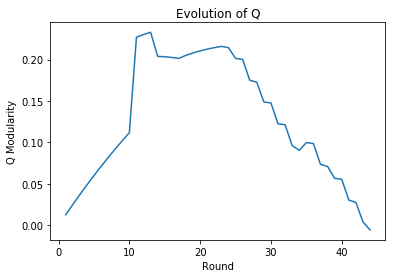

Maximum Q was achieved at round 13 and its value was 0.232906.

The best community structure is:
 {1: 1, 2: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 11: 1, 12: 1, 13: 1, 14: 1, 17: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 10: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2}
  ({<Node ID>: <Community ID>}) and there are 2 communities.
The graph at the best was:


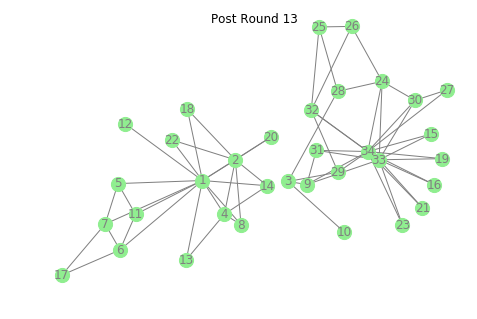

It took 236.400000 seconds ( 3.900000 mins ) until the network reached the best community structure.
(Please check the saved figures under "./Data/Figures")


In [78]:
# The main code to repeat Stage1-Stage4

print('Data contains %d nodes and %d edges.' % (len(nodes), nb_edges_initial))
print('nb_thread = %d, nb_slice = %s \n' % (nb_thread, str(nb_slice)))

# Parameter initialisation
k_iter = 1  # Number of edges to be removed at each round. (default value = 1)
r = 1  # Round
removed_edges=[]
nb_tup_hist = []
Q = 0
Q_hist = []
elist_hist = []
community_hist = []
t_hist, t_hist_st1, t_hist_st2, t_hist_st3, t_hist_st4, t_hist_round = [], [], [], [], [], []
t_initial = time.time()

# Loop the rounds as long as Q is positive
while Q >= 0:
    print("ROUND", r, "STARTED!")
    
## Stage1
    t_start = time.time() 
    t_st1_start = time.time()
    act_counter = 1
    ite = 1
    
    while act_counter > 0:  # Repeat Stage1 until all the tuples become inactive state
        rdd = sc.parallelize(output, numSlices=nb_slice)  # Specify the number of partitions of the new RDD

    # <Stage1 Map>
        # Doing Map
        t1 = time.time()
        pos_map1 = rdd.flatMap(stage1_map)
    # <Stage1 Reduce>
        # Doing Reduce
        red1_twokeys = pos_map1.map(lambda x: ((x[0],x[1][0]), x[1][1:]))
        red1_grouped = red1_twokeys.reduceByKey(join)
        red1_weighted = red1_grouped.map(stage1_reduce)
        # Collecting Reduce results
        record = red1_weighted.map(twokeys_to_onekey).collect()
        t2 = time.time()
        
        # for-loop to flatten the grouped values (non-parallelized)
        new = []
        for i in range(len(record)):
            if type(record[i][1][1]) is list:
                record[i]
                key = record[i][0]
                srcId = [record[i][1][0]]
                others = record[i][1][1:]
                for j in range(len(others)):
                    s = srcId.copy()
                    o = others[j]
                    s.extend(o)
                    newrec = (key, s)
                    new.append(newrec)
        pos_red1 = list(filter(lambda item: type(item[1][1]) != list, record))  # Save records with only one value
        pos_red1.extend(new)  # Add records which had multiple values
        output = pos_red1.copy()
        
        # Fill in adjList before going to next iteration    
        for i in range(len(output)):
            if output[i][1][5] == []:
                for j in range(len(adj_list)):
                    if adj_list[j][0] == output[i][0]:
                        output[i][1][5] = adj_list[j][1:len(adj_list[j])]
                        break
        act_counter = 0
        for i in range(len(output)):
            if output[i][1][2] == 'a':
                act_counter += 1
        print("\r  Stage 1 iteration %d finished. There are %d / %d active tuples left.       "
              % (ite, act_counter, len(output)), end="")
        nb_tup_hist.append(len(output))
        ite += 1
    stage1_output = output.copy()
    t_end = time.time()
    elapsed_time = t_end-t_start
    elapsed_time_min = elapsed_time/60
    print("\n  Stage 1 finished..", end=" ")
    t_st1_end = time.time()

## Stage2
    # <Stage2 Map>
    t_st2_start = time.time()
    pre_map2 = sc.parallelize(stage1_output, numSlices=nb_slice)  # Specify the number of partitions of the new RDD
    pos_map2 = pre_map2.filter(lambda x: x[0] > x[1][0]).flatMap(stage2_map)
    # <Stage2 Reduce>
    pos_red2_directed = pos_map2.reduceByKey(add)
    # Ignore the order of node ID at each edge and run reduceByKey(add) again
    pos_red2 = pos_red2_directed.map(lambda x: ((x[0][1], x[0][0]), x[1]) if x[0][0] > x[0][1] else x).reduceByKey(add)
    print(" Stage 2 finished..", end=" ")
    t_st2_end = time.time()
    
## Stage3
    # <Stage3 Map & Reduce>
    t_st3_start = time.time()
    distributed_cache = pos_red2.map(lambda x: (x[1], x[0])).sortByKey(False).map(lambda x: (x[1], x[0])).take(k_iter)
    top5 = pos_red2.map(lambda x: (x[1], x[0])).sortByKey(False).map(lambda x: (x[1], x[0])).take(5)
    #print("Edge betweenness Score Top 5 is:", top5)   
    removed_edges.append(distributed_cache)
    print(" Stage 3 finished..", end=" ")
    t_st3_end = time.time()
    
## Stage4
    # <Stage4 Map & Reduce>
    t_st4_start = time.time()
    pos_map4 = pre_map2.flatMap(stage4_map)
    pos_red4 = pos_map4.reduceByKey(stage4_reduce).flatMap(revision)
    output = pos_red4.collect()
    elist = from_tuples_to_edgelist(output)
    print(" Stage 4 finished..")
    t_st4_end = time.time()

# Save graph
    draw_graph(elist, r)
    plt.close()

# Update adjacency list 
    adj_list = []
    for i in range(len(output)):
        targ = [output[i][0]]
        targ.extend(output[i][1][5])
        adj_list.append(targ)
    adj_list = set(map(tuple, adj_list))  # Remove duplicates
    adj_list = list(adj_list)
    adj_list = list(map(list, adj_list))
    
# Calculate Q
    Q_fun_result = Q_modularity(elist, nodes)
    Q = Q_fun_result[0]
    community = Q_fun_result[1]
    
# Store the time histories
    t_hist_st1.append(t_st1_end - t_st1_start)
    t_hist_st2.append(t_st2_end - t_st2_start)
    t_hist_st3.append(t_st3_end - t_st3_start)
    t_hist_st4.append(t_st4_end - t_st4_start)

# Store the result histories
    Q_hist.append(Q)
    elist_hist.append(elist)
    community_hist.append(community)
    t_hist.append(time.time()-t_initial)
    t_r_end = time.time()
    t_hist_round.append(t_r_end - t_start)
    r_time = t_r_end - t_start
    print('  Round %d took %f seconds ( %f mins ).'
         % (r, round(r_time, 1), round(r_time/60, 1)))
    print('  ( Q: %f, [Removed edge(s), Edge betweenness]: %s )'
         % (Q, str(distributed_cache)))
    
    r += 1  # Go to next round

# Save the total execution time
t_terminal = time.time()
total_time = t_terminal - t_initial

# Give the summaries
print('Since the Q modularity reached a negative value, we ended the calculations.\n')
print('All the ', r-1, 'rounds have finished.')
print('Total execution time was %f seconds ( %f mins )\n'
     % (round(total_time, 1), round(total_time/60, 1)))

# Draw a graph of the modularity Q's evolution
x_axis = [x+1 for x in range(r-1)]
plt.plot(x_axis, Q_hist)
plt.title("Evolution of Q")
plt.xlabel("Round")
plt.ylabel("Q Modularity")
plt.savefig('./Data/Figures/Q_Modularity_evolution.png')
plt.show()

# Save information on the best community structure
Q_best = Q_hist[np.argmax(Q_hist)]
r_best = np.argmax(Q_hist) + 1
elist_best = elist_hist[np.argmax(Q_hist)]
community_best = community_hist[np.argmax(Q_hist)]
t_best = t_hist[np.argmax(Q_hist)]

# Comment on the best community structure
print('Maximum Q was achieved at round %d and its value was %f.\n' % (r_best, Q_best))
print('The best community structure is:\n', community_best)
print('  ({<Node ID>: <Community ID>}) and there are %d communities.' % len(set(community_best.values())))
print('The graph at the best was:')
draw_graph(elist_best, r_best)
plt.show()
print('It took %f seconds ( %f mins ) until the network reached the best community structure.'
      % (round(t_best, 1), round((t_best)/60, 1)))
print('(Please check the saved figures under "./Data/Figures")')

- Here we create a gif animation to visualise the edge-cutting process during the rounds.

In [289]:
#!brew install imagemagick
!convert -layers optimize -loop 0 -delay 30 Data/Figures/Post_Round_*.png Data/Figures/Edge_Cutting.gif
HTML('<img src="Data/Figures/Edge_Cutting.gif">')

- (Re-execution steps to collect results with different number of threads):
    - Jump back to <a href='#Spark Configuration'>6.1. Spark Configuration</a> to change the number of threads. (nb_thread = [1, 2, 3, 4, 5, 6])
    - Then re-execute the 3 cells from <a href='#Adjacency List Creation'>here</a>.
    - Then re-execute <a href='#Rounds Stage1-4'>6.8. Rounds Stage1-4</a> with 'Run All Below'.

## 4. Result & Discussion

 - From the best community structure, we can verify that the members of the karate club are grouped into two different communities (factions) having nodeId=1 (instructor) and nodeId=33 (captain) at the centre of each of the communities.
 
 
 - [Discussion points]:  
    4.1.) Analyse the per-stage execution time in terms of stage (type of operation), round, and nb_thread.  
    4.2.) Compare execution time with different number of threads (nb_thread = [1, 2, 3, 4, 5, 6]).  
    4.3.) Try with different datasets with different size.

### 4.1. Benchmark Result of Execution Time over Rounds
- Computation cost is the highest in Stage 1, followed by Stage 3, Stage 4 and Stage 2. This is an intuitive result as Stage 1 has iteration (Breadth-First Search) in its own.
- Although Stage 1 includes non-parallelised part, we can think this part to be negligible in computation time as it accounts for only 0.05%~3% of that of parallerised part.

In [190]:
stage_time_dict[nb_thread] = (sum(t_hist_st1), sum(t_hist_st2), sum(t_hist_st3), sum(t_hist_st4))
total_time_dict[nb_thread] = total_time

In [98]:
# soc-karate.txt
# Load saved result
stage_time_dict =  {6: (448.33299350738525, 6.032868385314941, 272.259966135025, 82.32897520065308), 5: (425.3946487903595, 6.164778470993042, 264.985004901886, 88.60664057731628), 4: (406.52807569503784, 6.528095960617065, 236.03210425376892, 82.96112656593323), 3: (586.6379969120026, 4.75326681137085, 382.6648168563843, 106.80774164199829), 2: (935.9590084552765, 5.649181365966797, 633.241316318512, 183.8122489452362), 1: (2272.0344178676605, 7.395992040634155, 778.6376185417175, 364.8658277988434)}
total_time_dict =  {6: 831.9653630256653, 5: 790.1284930706024, 4: 736.5315499305725, 3: 1104.0195088386536, 2: 1762.3882937431335, 1: 3504.687798023224}

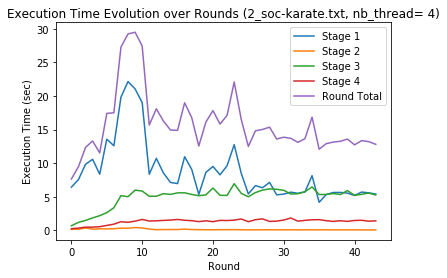

In [99]:
plt.plot(t_hist_st1, label='Stage 1')
plt.plot(t_hist_st2, label='Stage 2') 
plt.plot(t_hist_st3, label='Stage 3')
plt.plot(t_hist_st4, label='Stage 4')
plt.plot(t_hist_round, label='Round Total')

plt.title('Execution Time Evolution over Rounds (' + file + ', nb_thread= '+ str(nb_thread) + ')') 
plt.legend(loc='upper right')
plt.xlabel("Round"), plt.ylabel("Execution Time (sec)")
plt.savefig('./Data/Figures/Time_over_Rounds' + str(nb_thread) + '.png')

### 4.2. Benchmark Result of Execution Time over Threads
- There is decreasing marginal effect of number of threads (cores) used on time execution
- Since the number of (logical) CPU is 4 on our laptop, the graph stays flat for nb_thread > 4.

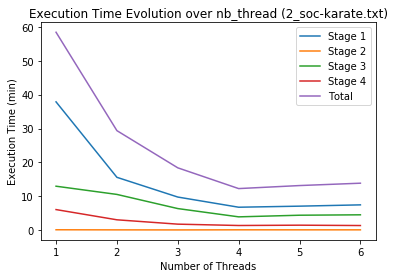

In [100]:
# Sort the dictionary by key (nb_thread)
time_list_sorted = sorted(stage_time_dict.items(), key=lambda x: x[0], reverse=False)
total_time_list_sorted = sorted(total_time_dict.items(), key=lambda x: x[0], reverse=False)

x, y1, y2, y3, y4, y = [], [], [], [], [], []

for i in range(len(time_list_sorted)):
    x.append(str(time_list_sorted[i][0]))
    y1.append(time_list_sorted[i][1][0])
    y2.append(time_list_sorted[i][1][1])
    y3.append(time_list_sorted[i][1][2])
    y4.append(time_list_sorted[i][1][3])
    y.append(total_time_list_sorted[i][1])

y1_m, y2_m, y3_m, y4_m, y_m = np.array(y1)/60, np.array(y2)/60, np.array(y3)/60, np.array(y4)/60, np.array(y)/60

plt.plot(x, y1_m, label='Stage 1')
plt.plot(x, y2_m, label='Stage 2')
plt.plot(x, y3_m, label='Stage 3')
plt.plot(x, y4_m, label='Stage 4')
plt.plot(x, y_m, label='Total')
plt.title('Execution Time Evolution over nb_thread (2_soc-karate.txt)') 
plt.legend(loc='upper right')
plt.xlabel("Number of Threads"), plt.ylabel("Execution Time (min)")
plt.savefig('./Data/Figures/Time_over_Threads.png')

### 4.3. Comparison with Other Datasets

- We have executed the code on the first four datasets.

| No. | Data set     |  Number of nodes & edges  |
|--- |-----------| ------------  |
| **1** |**test.txt** | **21 nodes, 31 edges**  |  
| **2** |**soc-karate.txt** | **34 nodes, 78 edges**  | 
| **3** |**Test100.txt** | **103 nodes, 239 edges**  |  
| **4** |**soc-physicians.txt** | **241 nodes, 923 edges**  | 
| 5 |soc-ANU-residence_large.txt | 217 nodes, 1839 edges  |
| 6 |email-Eu-core.txt | 986 nodes, 16064 edges  | 

In [101]:
# 1_test.txt
# Load saved result
stage_time_dict_ =  {4: (16.166771411895752, 1.1112568378448486, 12.025902032852173, 2.623095989227295), 3: (15.030799388885498, 1.2432641983032227, 12.677597522735596, 2.814807653427124), 2: (14.170666217803955, 1.2695255279541016, 11.35614800453186, 2.3849873542785645), 1: (17.641211986541748, 1.238182544708252, 5.371529579162598, 3.2237327098846436), 5: (16.972058057785034, 1.218146562576294, 13.082455396652222, 3.2587146759033203), 6: (17.16669225692749, 1.1821753978729248, 14.264925003051758, 3.255084753036499)}
total_time_dict_ =  {4: 34.48276400566101, 3: 34.313719034194946, 2: 31.758249044418335, 1: 29.94857907295227, 5: 37.73854899406433, 6: 38.986210107803345}

(Text(0.5, 0, 'Number of Threads'), Text(0, 0.5, 'Execution Time (min)'))

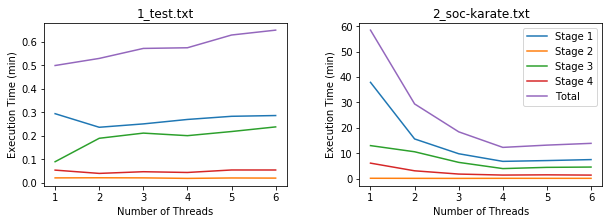

In [116]:
# Comparison with 1_test.txt result
time_list_sorted_ = sorted(stage_time_dict_.items(), key=lambda x: x[0], reverse=False)
total_time_list_sorted_ = sorted(total_time_dict_.items(), key=lambda x: x[0], reverse=False)

x_, y1_, y2_, y3_, y4_, y_ = [], [], [], [], [], []

for i in range(len(time_list_sorted)):
    x_.append(str(time_list_sorted_[i][0])), y_.append(total_time_list_sorted_[i][1])
    y1_.append(time_list_sorted_[i][1][0]), y2_.append(time_list_sorted_[i][1][1])
    y3_.append(time_list_sorted_[i][1][2]), y4_.append(time_list_sorted_[i][1][3])

y1_m_, y2_m_, y3_m_, y4_m_, y_m_ = np.array(y1_)/60, np.array(y2_)/60, np.array(y3_)/60, np.array(y4_)/60, np.array(y_)/60

plt.figure(figsize=(10, 3))
plt.subplots_adjust(wspace=0.3, hspace=0.6)

plt.subplot(1,2,1)
plt.plot(x_, y1_m_, label='Stage 1'), plt.plot(x_, y2_m_, label='Stage 2')
plt.plot(x_, y3_m_, label='Stage 3'), plt.plot(x_, y4_m_, label='Stage 4')
plt.plot(x_, y_m_, label='Total')
plt.title('1_test.txt') 
plt.xlabel("Number of Threads"), plt.ylabel("Execution Time (min)")

plt.subplot(1,2,2)
plt.plot(x, y1_m, label='Stage 1'), plt.plot(x, y2_m, label='Stage 2')
plt.plot(x, y3_m, label='Stage 3'), plt.plot(x, y4_m, label='Stage 4')
plt.plot(x, y_m, label='Total')
plt.title('2_soc-karate.txt') 
plt.legend(loc='upper right')
plt.xlabel("Number of Threads"), plt.ylabel("Execution Time (min)")

- From the above graph, we can see that execution time for *'1_test.txt'* dataset is actually **increasing** with number of threads. This means that the data size is so small that partitioning of data **harms** smooth computation rather than improves it.
- As it can be confirmed from the next set of graphs, each iteration of *'1_test.txt'* dataset processes only 38-857 tuples (median=123, mean=222), whereas *'2_soc-karate.txt'* dataset processes 150-21552 tuples (median=812, mean=2122). Therefore, we can suggest, in general, that parallelised computation (Spark) can be useful if the average size of the processed data for each operation exceeds 1000.

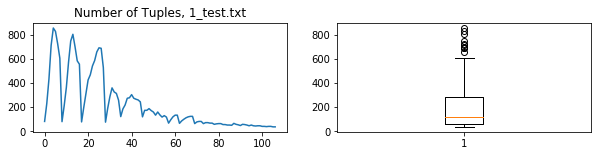

,count,mean,std,min,25%,50%,75%,max
0,107.0,222.373832,221.566998,38.0,65.0,123.0,283.0,857.0


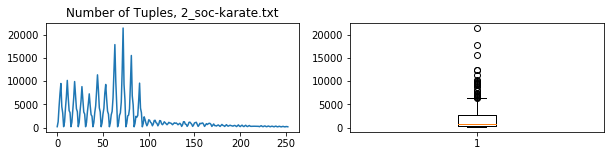

,count,mean,std,min,25%,50%,75%,max
0,253.0,2122.403162,3171.810896,150.0,302.0,812.0,2754.0,21552.0


In [139]:
nb_tup_hist_test = [83, 231, 435, 713, 857, 829, 727, 607, 81, 213, 365, 573, 749, 805, 701, 585, 557, 79, 199, 313,\
                    427, 469, 543, 587, 659, 693, 689, 529, 77, 191, 287, 361, 327, 315, 259, 123, 187, 219, 275, 279,\
                    305, 275, 267, 261, 245, 121, 175, 175, 189, 173, 161, 135, 161, 137, 119, 131, 119, 69, 97, 121,\
                    135, 135, 67, 87, 101, 113, 121, 125, 125, 65, 79, 83, 83, 65, 73, 73, 69, 69, 59, 63, 65, 65, 57,\
                    57, 53, 53, 51, 67, 59, 55, 49, 59, 57, 53, 47, 53, 47, 45, 47, 47, 42, 42, 40, 42, 42, 38, 38]
plt.figure(figsize=(10, 2))
plt.subplot(1,2,1)
plt.title('Number of Tuples, 1_test.txt')
plt.plot(nb_tup_hist_test);
plt.subplot(1,2,2)
plt.boxplot(nb_tup_hist_test);
plt.show()

arr1 = np.array(nb_tup_hist_test)
display(pd.DataFrame(pd.Series(arr1.ravel()).describe()).transpose())

nb_tup_hist_karate = nb_tup_hist
plt.figure(figsize=(10, 2))
plt.subplot(1,2,1)
plt.title('Number of Tuples, 2_soc-karate.txt')
plt.plot(nb_tup_hist_karate);
plt.subplot(1,2,2)
plt.boxplot(nb_tup_hist_karate);
plt.show()

arr2 = np.array(nb_tup_hist_karate)
display(pd.DataFrame(pd.Series(arr2.ravel()).describe()).transpose())

- In the next graph, it is shown that the execution time result for the 4 datasets exhibits exponential growth of execution time in number of nodes and edges.

Text(0.5, 1.0, 'First Round Execution Time Comparison (#Node, #Edge)')

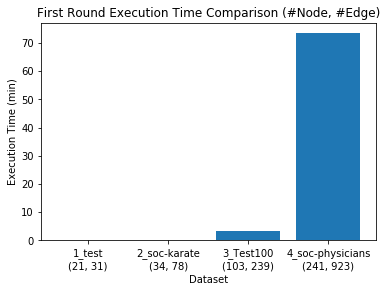

In [304]:
plt.bar(['1_test\n(21, 31)', '2_soc-karate\n(34, 78)', '3_Test100\n(103, 239)', '4_soc-physicians\n(241, 923)'],
        [2.1/60, 10.0/60, 201.4/60, 4407.5/60])
plt.xlabel("Dataset"), plt.ylabel("Execution Time (min)")
plt.title('First Round Execution Time Comparison (#Node, #Edge)')

- As explained in **1. Introduction & Literature Review**, the complete community structure algorithm is $\mathcal{O}(E^2N)$ (with E edges and N nodes), and the total shortest-path betweenness for all edges takes $\mathcal{O}(EN)$ in its computation. Thus, $\mathcal{O}(EN)$ can be regarded as the per-round computation cost.


- **[Definition of Landau's Symbol]**
  - We write $f(x) =\mathcal{O}(f(x))$ for $ x \rightarrow \infty$
if and only if, $\exists n$ and $c$ (constants), s.t. $\forall x > n$, $|f(x)| \le c |g(x)|$ 
  - Intuitively, this means that f does not grow faster than g.
  
  
- Below graph decribes $\mathcal{O}(EN)$ with our empirical result in red points.
- The blue surface in the graph means execution time order in theory over different number of nodes and edges, and the red triangle points describe the empirical results of the time order over 5 different datasets.

- For larger datasets, for example for *5_soc-ANU-residence_large.txt* with 1839 edges, we have confirmed that each Stage 1 iteration processes more than a million tuples. In order to process these datasets, distributed computation over multiple computers would be required (our PC was not sufficient to run data with such large size).

In [299]:
%matplotlib notebook

<IPython.core.display.Javascript object>


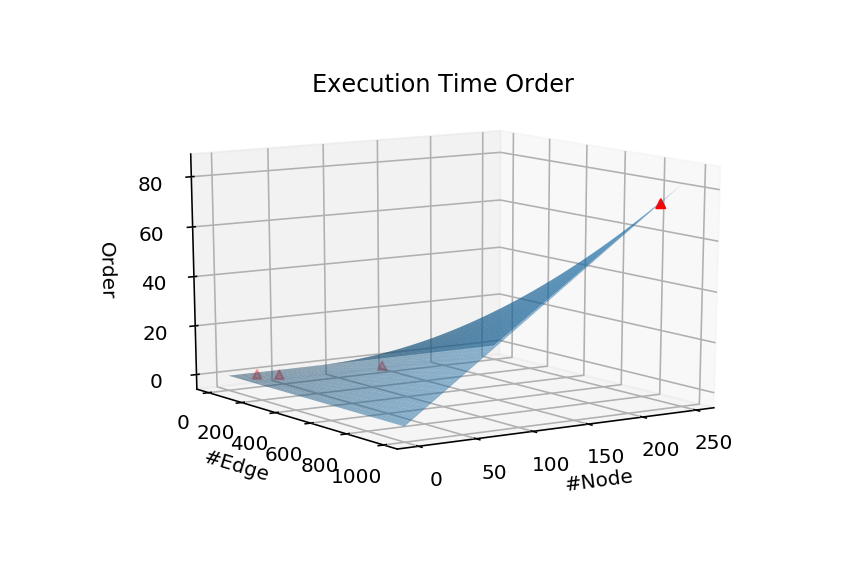

In [298]:
n = range(250)
e = range(1000)
N, E = np.meshgrid(n, e)
O = N*E/3000  # 1/3000 can be regarded as constant c

n = [21, 34, 103, 241]
e = [31, 78, 239, 923]
o = [2.1/60, 10.0/60, 201.4/60, 4407.5/60]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(n, e, o, c='r', marker='^')
ax.plot_surface(N, E, O, alpha=0.5)
ax.set_xlabel('#Node')
ax.set_ylabel('#Edge')
ax.set_zlabel('Order')
ax.set_title("Execution Time Order")
ax.invert_xaxis()
plt.show()

## 5. Conclusion

- Our algorithm has successfully detected the two communities in the benchmark network dataset.


- As per total execution times disclosed on graphs above, we observe a nice improvement of time saved in using parallelisation on threads. On most datasets, using 4 or 5 threads divide execution time by more than 3.


- Effects of parallelisation are mostly visible on the first stage of the algorithm for this small dataset, which is by far the most time-consuming, especially due to the reduce part at each iteration."


- Looking at the whole process, increasing the number of threads has almost a linear effect on execution time reduction for large networks.


- Whatever the size of the dataset we are working on, parallelisation of computations has significant impacts on time and indirectly on energy consumed. In order to process larger datasets (e.g. over than 1000 nodes and thousands of edges), it is recommended to use a Hadoop cluster (on such as AWS and Microsoft Azure) to run distributed computing over multiple workers.


- Further improvement of code can be possible, for example, by using Spark DataFrame for the list of tuples. Any other methods to make the code more efficient could reduce the execution time.


- It is also possible to remove multiple edges (that have the highest edge betweenness scores) rather than only one edge per round, whose approximation technique permits us to significantly decrease the computation load.


## 6. References

1) S. Moon, et al., *"Parallel community detection on large graphs with MapReduce and GraphChi"*, Data Knowl. Eng. (2015)  

2) M.E. Newman, M. Girvan, *"Finding and evaluating community structure in networks"*, Phys. Rev. E 69 (2) (2004)  

3) V.D. Blondel, et al., *"Fast unfolding of communities in large networks"*, Journal of Statistical Mechanics: Theory and Experiment (2008)  

4) P. Pons and M. Latapy, *"Computing communities in large networks using random walks"*, J. Graph Algorithms Appl. (2005) 

5) R. Algesheimer, et al., *"A Comparative Analysis of Community Detection Algorithms on Artificial Networks"*, Nature (2016)  